In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import itertools
import pandas as pd
import numpy as np
import zipfile
import os

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

In [4]:
with zipfile.ZipFile("/content/zillow_data.csv.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [5]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [6]:
ny=df[(df['City']=='New York')]
area = pd.read_csv('manhattan_brooklyn_zip.csv')
area.head()

,RegionName,District
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


In [7]:
ny1 = pd.merge(ny, area, how='left', on='RegionName')

ny2 = ny1[ny1['District'].notnull()]
ny2.groupby('District').count()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
District,,,,,,,,,,,,,,,,,,,,,
Brooklyn,29,29,29,29,29,29,29,25,25,25,...,29,29,29,29,29,29,29,29,29,29
Manhattan,4,4,4,4,4,4,4,1,1,1,...,4,4,4,4,4,4,4,4,4,4


In [8]:
ny3 = ny2[ny2['District']=='Brooklyn']
ny3.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
1,62037,11226,New York,NY,New York,Kings,11,162000.0,162300.0,162600.0,...,851000,853900,870000,885100,887800,890500,901700,930700,963200,Brooklyn
3,62045,11235,New York,NY,New York,Kings,14,190500.0,191000.0,191500.0,...,777300,788800,793900,796000,799700,806600,810600,813400,816200,Brooklyn
9,62040,11230,New York,NY,New York,Kings,48,230100.0,230800.0,231500.0,...,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400,Brooklyn
10,62020,11209,New York,NY,New York,Kings,50,255700.0,256600.0,257300.0,...,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800,Brooklyn
11,62023,11212,New York,NY,New York,Kings,54,125000.0,125000.0,125000.0,...,387000,394600,401500,407900,414900,422300,426300,427100,428400,Brooklyn


In [9]:
ny4 = ny3.drop(['RegionID','City','State','Metro','CountyName','SizeRank','District'], axis ='columns')

ny4

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1,11226,162000.0,162300.0,162600.0,163000.0,163400.0,164000.0,164700.0,165700.0,166800.0,...,860200,851000,853900,870000,885100,887800,890500,901700,930700,963200
3,11235,190500.0,191000.0,191500.0,192000.0,192500.0,193000.0,193600.0,194300.0,195300.0,...,767300,777300,788800,793900,796000,799700,806600,810600,813400,816200
9,11230,230100.0,230800.0,231500.0,232100.0,232800.0,233600.0,234700.0,235900.0,237500.0,...,1079200,1082700,1082800,1084900,1091200,1102400,1120200,1141600,1170000,1195400
10,11209,255700.0,256600.0,257300.0,258100.0,258900.0,259800.0,260900.0,262000.0,263600.0,...,1005000,1013400,1019500,1024400,1024900,1018900,1023500,1029200,1023000,1015800
11,11212,125000.0,125000.0,125000.0,125000.0,125100.0,125100.0,125000.0,124800.0,124600.0,...,380000,387000,394600,401500,407900,414900,422300,426300,427100,428400
12,11214,191000.0,191200.0,191500.0,191900.0,192100.0,192400.0,192800.0,193200.0,193800.0,...,798000,805700,814200,820600,825000,826300,827600,830500,837300,844100
13,11221,133700.0,133700.0,133700.0,133700.0,133900.0,134000.0,134300.0,134700.0,135300.0,...,944500,948200,965300,984700,995000,998100,1000900,1015400,1037300,1048700
14,11229,183900.0,184200.0,184500.0,184800.0,185000.0,185100.0,185400.0,185600.0,186200.0,...,724100,730300,734500,735500,736100,741000,748100,755800,766200,775500
16,11234,172300.0,172100.0,171900.0,171600.0,171400.0,171300.0,171300.0,171300.0,171500.0,...,559400,563800,566400,565600,568700,575000,579400,583200,589400,593300
19,11215,225700.0,227500.0,229400.0,231600.0,234100.0,236900.0,239800.0,242900.0,246400.0,...,2173600,2201100,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900


In [10]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

dfm = melt_data(ny4)

dfm

,RegionName,Month,MeanValue
0,11226,1996-04-01,162000.0
1,11235,1996-04-01,190500.0
2,11230,1996-04-01,230100.0
3,11209,1996-04-01,255700.0
4,11212,1996-04-01,125000.0
...,...,...,...
7680,11222,2018-04-01,1721100.0
7681,11205,2018-04-01,2248400.0
7682,11217,2018-04-01,3656000.0
7683,11231,2018-04-01,3044500.0


In [11]:
dfm.set_index('Month', inplace = True)

dfm.head(10)

,RegionName,MeanValue
Month,,
1996-04-01,11226,162000.0
1996-04-01,11235,190500.0
1996-04-01,11230,230100.0
1996-04-01,11209,255700.0
1996-04-01,11212,125000.0
1996-04-01,11214,191000.0
1996-04-01,11221,133700.0
1996-04-01,11229,183900.0
1996-04-01,11234,172300.0


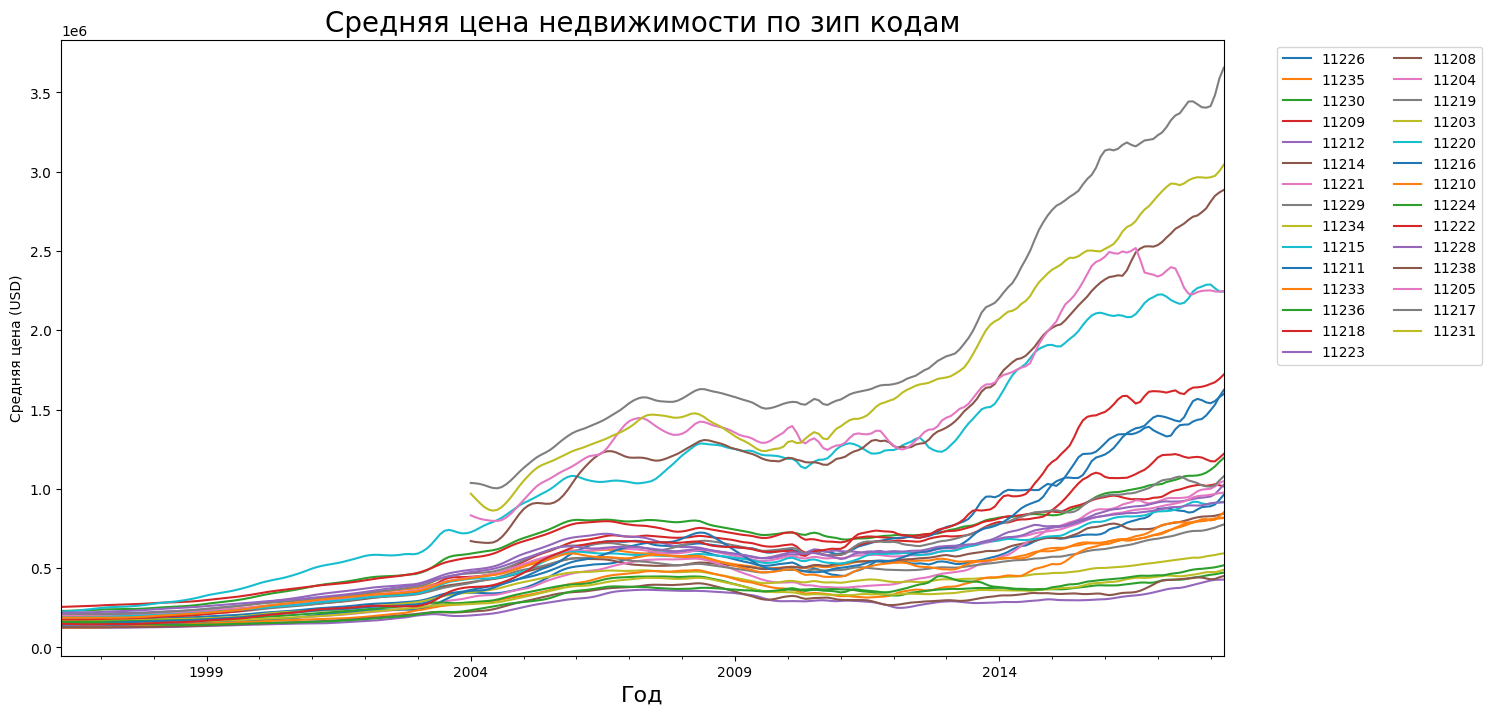

In [12]:
for zipcode in dfm.RegionName.unique():
    temp_df = dfm[dfm.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Год", fontsize = 16)
plt.ylabel("Средняя цена (USD)")
plt.title('Средняя цена недвижимости по зип кодам', fontsize = 20);

In [16]:
dfm.RegionName.unique()

zip_dfs = []
zip_list = np.array([11231,11205,11217])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['RegionName']==x][['MeanValue']].copy()))

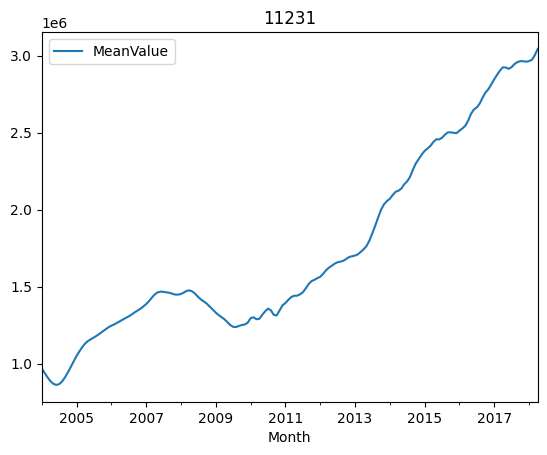

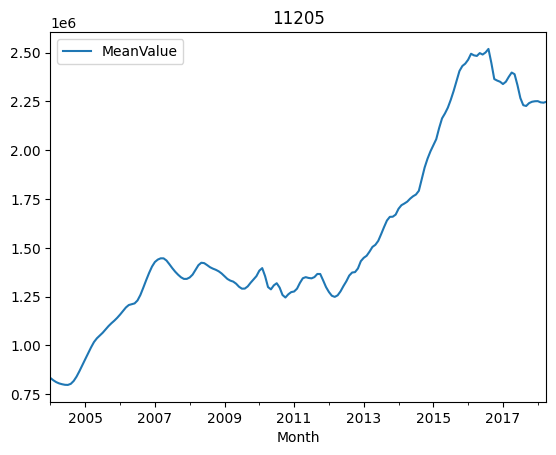

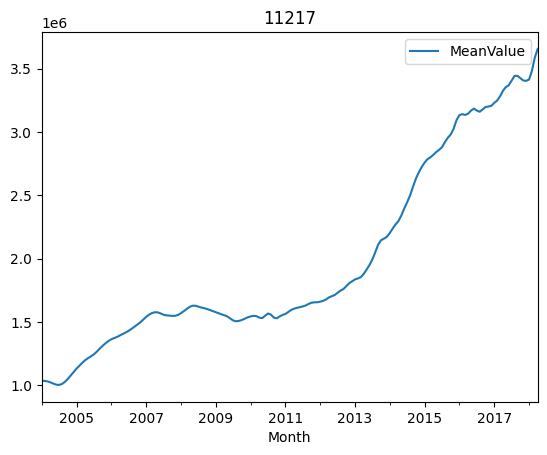

In [17]:
for df, name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(name)
    plt.show()

In [18]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [19]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [20]:
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 11231 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5423.9708093629815
Result for 11231 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4953.349694359713
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4343.500124754707
Result for 11231 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 3964.179365207574
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 4224.726704777125
Result for 11231 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4167.70854375729
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 3911.0932416918577
Result for 11231 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 3886.920566949921
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5271.202299206425
Result for 11231 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4873.687919164706
Result for 11231 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4438.507909420763
Result for 11231 ARIMA (0, 0, 1

In [21]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

(AIC) — широко используемый показатель статистической модели. По сути, он количественно определяет

1) степень соответствия и

2) простоту/экономность модели в единой статистике.

При сравнении двух моделей, как правило, лучше та, у которой меньший AIC.

In [22]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]
best_para

,name,pdq,pdqs,AIC
127,11205,"(1, 1, 1)","(1, 1, 1, 12)",3275.267959
187,11217,"(1, 1, 1)","(0, 1, 1, 12)",3161.884562
63,11231,"(1, 1, 1)","(1, 1, 1, 12)",3114.322528


In [23]:
dfm['2017':]['MeanValue'].mean()

1195787.9310344828

In [24]:
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)

    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])

SARIMA Model Result for 11205
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7302      0.071     10.278      0.000       0.591       0.869
ma.L1          0.2318      0.033      7.053      0.000       0.167       0.296
ar.S.L12      -0.5738      0.086     -6.685      0.000      -0.742      -0.406
ma.S.L12      -0.0071      0.054     -0.131      0.895      -0.113       0.099
sigma2      1.344e+08   9.15e-11   1.47e+18      0.000    1.34e+08    1.34e+08
SARIMA Model Result for 11217
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4732      0.087      5.435      0.000       0.303       0.644
ma.L1          0.6258      0.064      9.720      0.000       0.500       0.752
ma.S.L12      -0.1747      0.043     -4.091      0.000      -0.258     

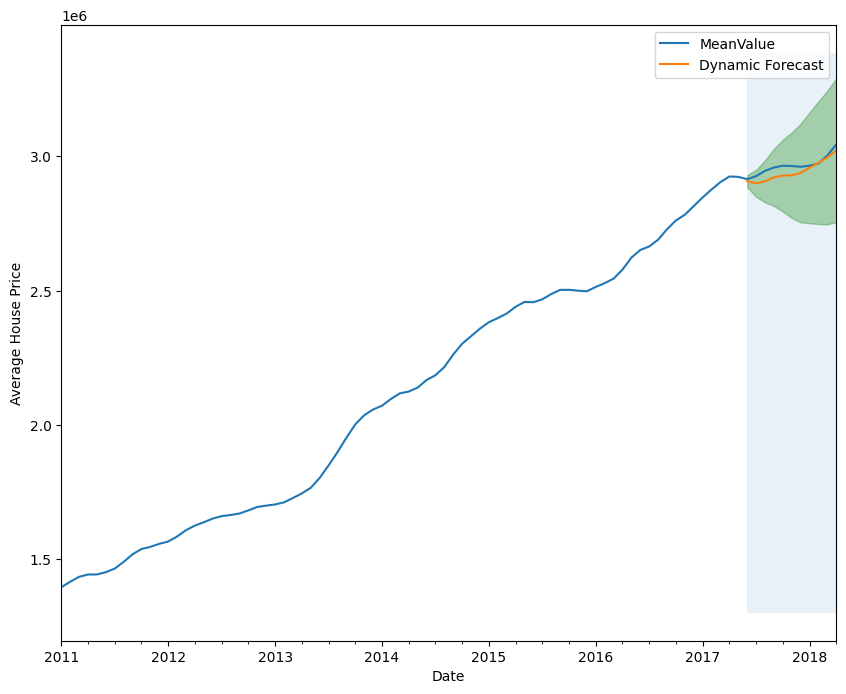

The Mean Squared Error of our forecasts is 25756.56


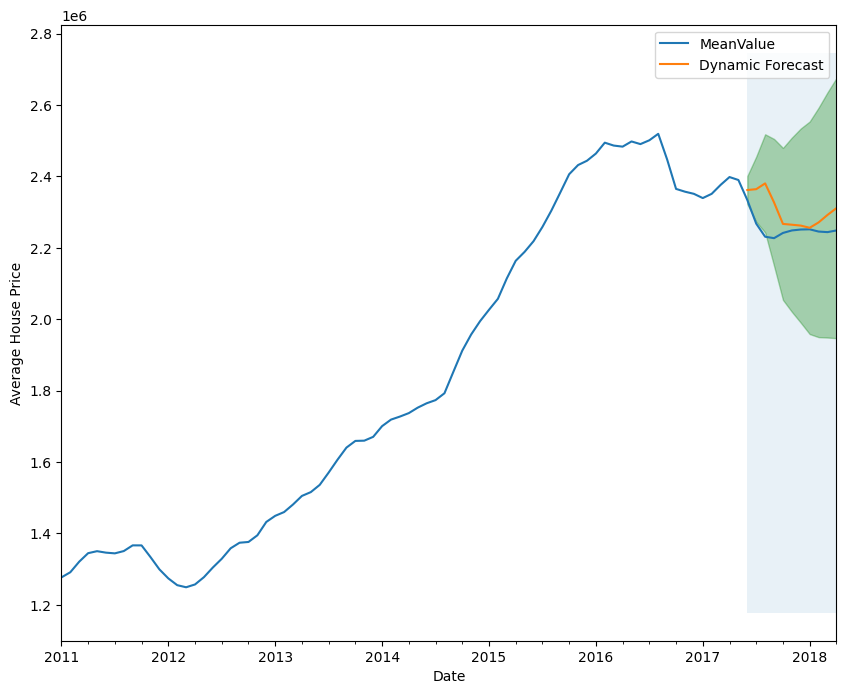

The Mean Squared Error of our forecasts is 67677.54


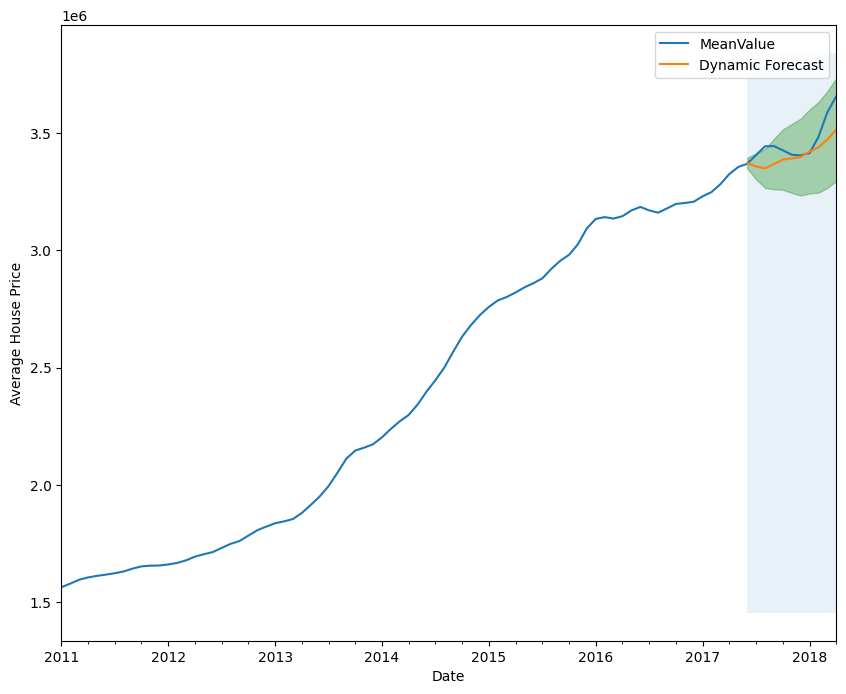

The Mean Squared Error of our forecasts is 70471.24


In [25]:
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)

    output = ARIMA_MODEL.fit()
    models.append(output)

    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-06-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-06-01':]['MeanValue']

    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-06-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2)))

    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)

summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value

In [26]:
summary_table

,Zipcode,Sqrt_MSE
0,11205,25756.564495
1,11217,67677.540755
2,11231,70471.236996


In [ ]:
forecast_table = pd.DataFrame()
current = []
forecast_3Yr = []
forecast_5Yr =[]
for zipcode, output, df in zip(Zipcode, models, zip_dfs):
    pred_3 = output.get_forecast(steps = 36)
    pred_conf_3 = pred_3.conf_int()
    forecast_3 = pred_3.predicted_mean.to_numpy()[-1]
    pred_5 = output.get_forecast(steps = 60)
    pred_conf_5 = pred_5.conf_int()
    forecast_5 = pred_5.predicted_mean.to_numpy()[-1]
    current.append(df['2018-04']['MeanValue'][0])
    forecast_3Yr.append(forecast_3)
    forecast_5Yr.append(forecast_5)

forecast_table['Zipcode'] = Zipcode
forecast_table['Current Value'] = current
forecast_table['3 Years Value'] = forecast_3Yr
forecast_table['5 Years Value'] = forecast_5Yr
forecast_table['3Yr-ROI']=(forecast_table['3 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']
forecast_table['5Yr-ROI']=(forecast_table['5 Years Value'] - forecast_table['Current Value'])/forecast_table['Current Value']

In [ ]:
forecast_table